In [1]:
from tectosaur2.nb_config import setup

setup()

# Topography


## Summary 

We're going to replicate the calculation from the previous section above except for a free surface with topography. The calculations will be identical except for the construction of the surface itself. As a result, there will be no narration. You can take a look through and cross reference the steps with the corresponding step in the previous section.  

To construct the mesh, I'll specify a parametrized topography curve with a Gaussian hill shape near the origin. Remember that in the parametrized description of curves accepted by `refine_surfaces`, the parameter (normally $t$) varies from -1 to 1.

## Solving for displacement from a fault below topography

In [2]:
import warnings
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, pts_grid
from tectosaur2.laplace2d import double_layer, hypersingular

In [3]:

surf_half_L = 1000
t = sp.symbols("t")
x = -surf_half_L * t
y = sp.exp(-(t ** 2) * 500000) * sp.Rational(1.0) - sp.Rational(1.0)
sp.Tuple(x, y)

(-1000*t, -1 + exp(-500000*t**2))

In [4]:
fault, topo = refine_surfaces(
    [
        (t, t * 0, 1 * ((t + 1) * -0.5)), # the fault
        (t, x, y) # the free surface
    ],
    gauss_rule(8),
    control_points=np.array([(0, 0, 10, 0.2)]),
)
print(
    f"The free surface mesh has {topo.n_panels} panels with a total of {topo.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 220 panels with a total of 1760 points.
The fault mesh has 8 panels with a total of 64 points.


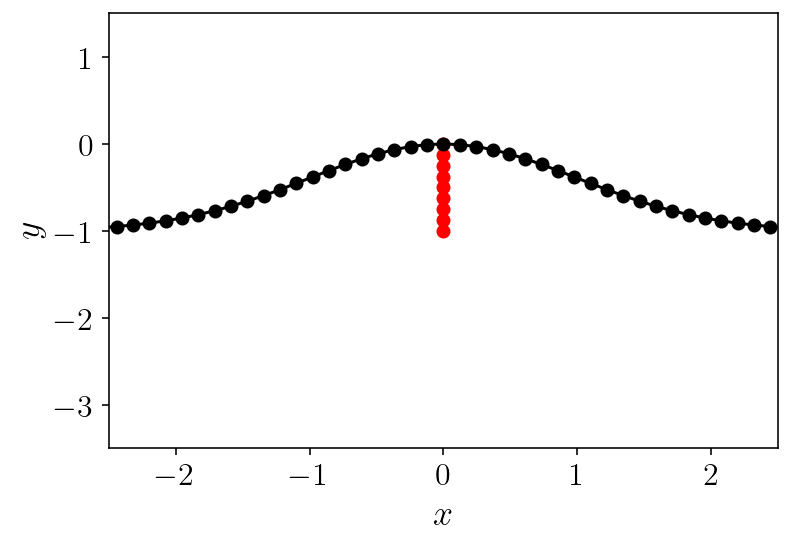

In [5]:
plt.plot(fault.panel_edges[:, 0], fault.panel_edges[:, 1], "r-o")
plt.plot(topo.panel_edges[:, 0], topo.panel_edges[:, 1], "k-o")
plt.xlim([-2.5, 2.5])
plt.ylim([-3.5, 1.5])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [6]:
%%time
# Specify singularities
singularities = np.array([
    [-surf_half_L,0],
    [surf_half_L,0],
    [0,0],
    [0,-1],
])

# Integrate!
(surf_disp_to_surf_disp, fault_slip_to_surf_disp), reports = integrate_term(
    double_layer,
    topo.pts,
    topo,
    fault,
    limit_direction=1.0,
    singularities=singularities,
    return_report=True
)


# Specify a constant unit slip along the fault.
slip = np.ones(fault.n_pts)

# rhs = B \Delta u
rhs = -fault_slip_to_surf_disp[:,0,:,0].dot(slip)

# lhs = I + A
lhs = np.eye(topo.n_pts) + surf_disp_to_surf_disp[:,0,:,0]

surf_disp = np.linalg.solve(lhs, rhs)

CPU times: user 440 ms, sys: 97.4 ms, total: 537 ms
Wall time: 207 ms


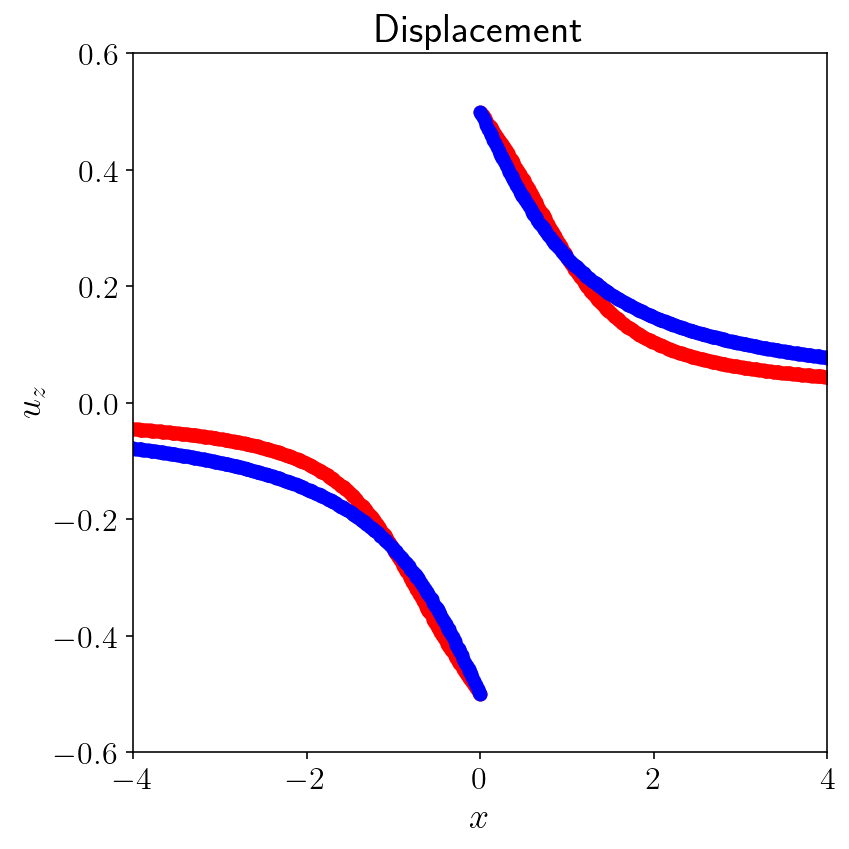

In [7]:
analytical = -np.arctan(-1 / topo.pts[:,0]) / np.pi
%matplotlib inline
plt.figure(figsize=(6, 6))
plt.plot(topo.pts[:, 0], surf_disp, "ro")
plt.plot(topo.pts[:, 0], analytical, "bo")
plt.xlabel("$x$")
plt.ylabel("$u_z$")
plt.title("Displacement")
plt.xlim([-4, 4])
plt.ylim([-0.6, 0.6])
plt.tight_layout()
plt.show()

## Interior evaluation of displacement and stress.

In [8]:
nobs = 200
zoomx = [-1.5, 1.5]
zoomy = [-2, 0]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

In [9]:
K = double_layer
(free_to_disp, fault_to_disp), report = integrate_term(
    double_layer,
    obs_pts,
    topo,
    fault,
    singularities=singularities,
    return_report=True,
)
interior_disp = -free_to_disp[:, 0, :, 0].dot(surf_disp) - fault_to_disp[:, 0, :, 0].dot(slip)

In [10]:
(free_to_stress, fault_to_stress), report = integrate_term(
    hypersingular,
    obs_pts,
    topo,
    fault,
    singularities=singularities,
    return_report=True,
)
interior_stress = -free_to_stress[:,:,:,0].dot(surf_disp) - fault_to_stress[:,:,:,0].dot(slip)
interior_sxz = interior_stress[:, 0]
interior_syz = interior_stress[:, 1]

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:201: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:208: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


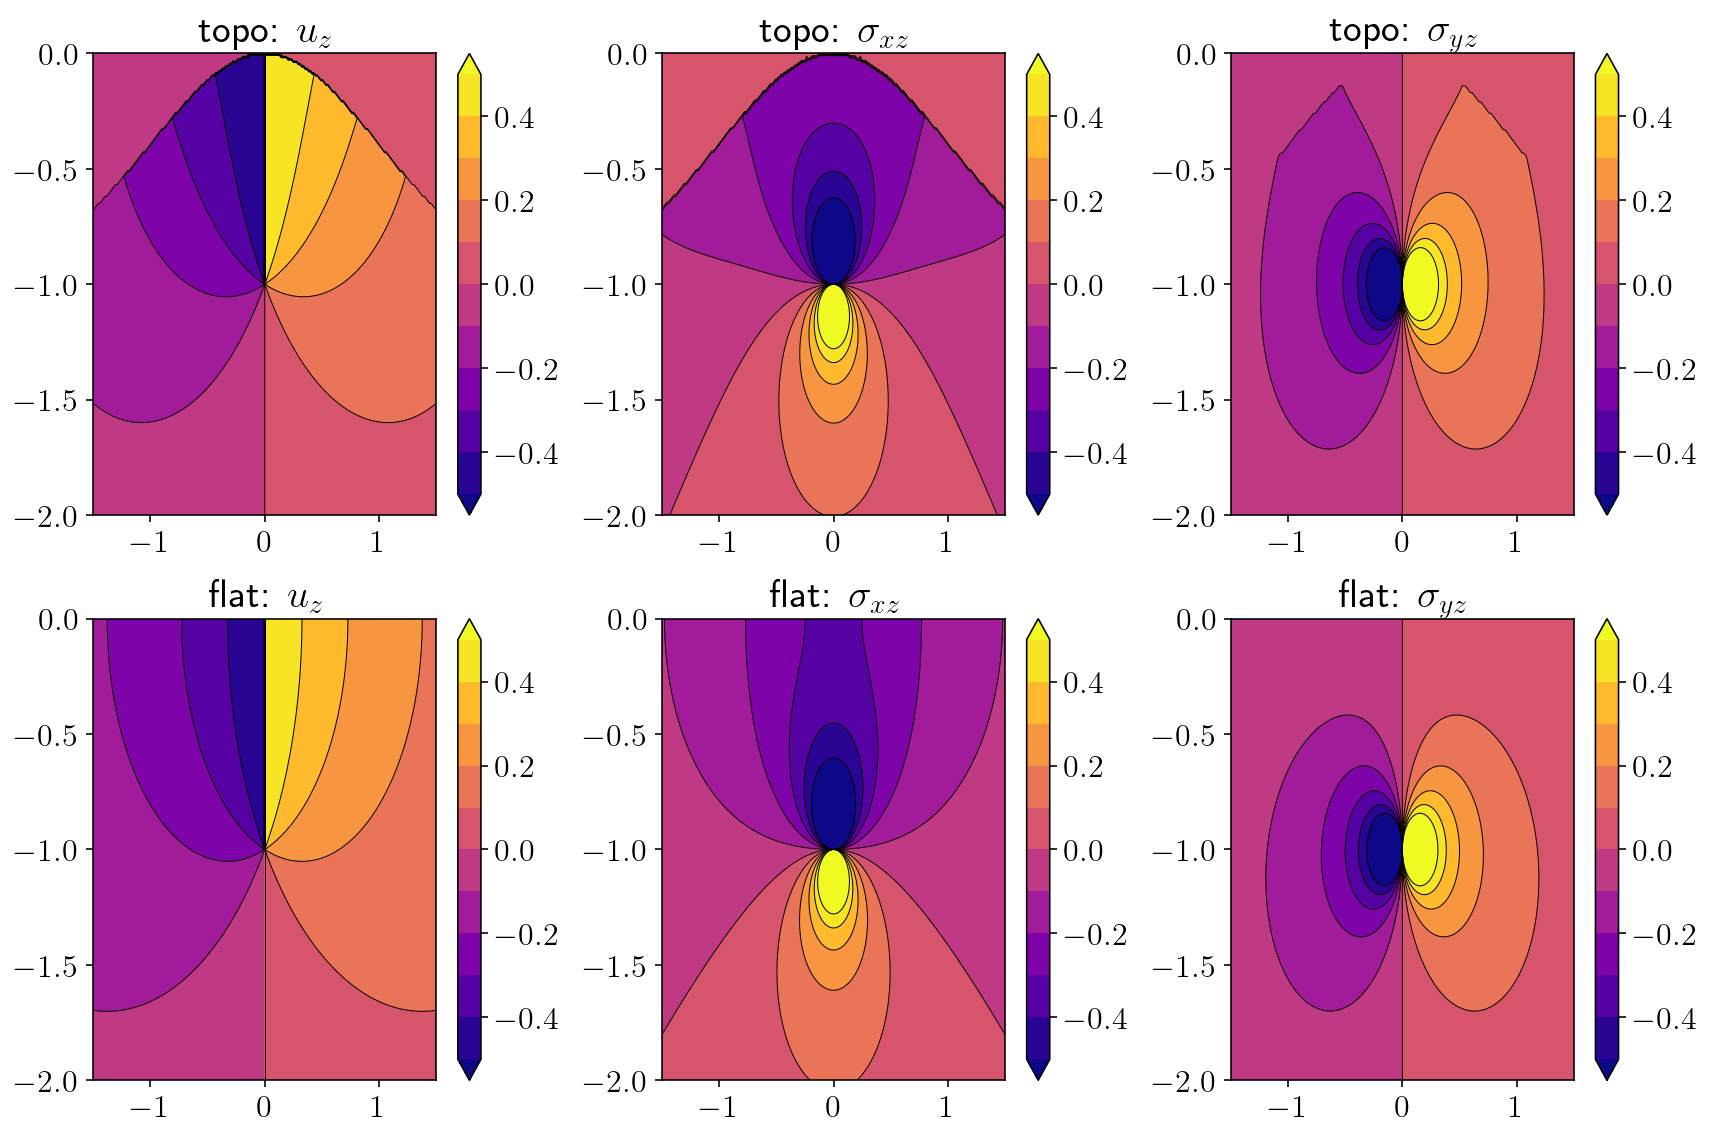

In [11]:
analytical_disp = (
    1.0 / (2 * np.pi) * (np.arctan((obsy + 1) / obsx) - np.arctan((obsy - 1) / obsx))
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    disp_err = np.log10(np.abs(interior_disp - analytical_disp))

rp = obsx ** 2 + (obsy + 1) ** 2
ri = obsx ** 2 + (obsy - 1) ** 2
analytical_sxz = -(1.0 / (2 * np.pi)) * (((obsy + 1) / rp) - ((obsy - 1) / ri))
analytical_syz = (1.0 / (2 * np.pi)) * ((obsx / rp) - (obsx / ri))
sxz_err = np.log10(np.abs(interior_sxz - analytical_sxz))
syz_err = np.log10(np.abs(interior_syz - analytical_syz))
plt.figure(figsize=(12, 8))

plots = [
    ("interior_disp", "topo: $u_z$"),
    ("interior_sxz", "topo: $\sigma_{xz}$"),
    ("interior_syz", "topo: $\sigma_{yz}$"),
    ("analytical_disp", "flat: $u_z$"),
    ("analytical_sxz", "flat: $\sigma_{xz}$"),
    ("analytical_syz", "flat: $\sigma_{yz}$"),
]
for i, (k, title) in enumerate(plots):
    plt.subplot(2, 3, 1 + i)
    plt.title(title)
    v = locals()[k].reshape((nobs, nobs))
    v2d = v.reshape((nobs, nobs))
    levels = np.linspace(-0.5, 0.5, 11)
    cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v2d,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    # plt.xlim([-0.01, 0.01])
    # plt.ylim([-0.02, 0.0])

plt.tight_layout()
plt.show()